In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, fnmatch

import scipy
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift,dct
from scipy import interpolate

from sklearn.preprocessing import Normalizer
scaler = Normalizer(norm='max')
import librosa

# Извлечение фич

In [26]:
coefs = []
path = 'D:/Учеба/Технопарк/Heart/'
A_folder_filt = path+'set_filt_1/'
# A_folder_filt = path+'set_1/'

i=0
scaler = Normalizer(norm='max')
for fil in os.listdir(A_folder_filt):
    fs, data = wavfile.read(A_folder_filt+fil)
    data = data[:120000]
    f, t, P = signal.spectrogram(data, fs,window='hamming',nperseg=500,noverlap=250)
    N = P.shape[1]

    #-----------------------------------------------------------------------------
    # Calculating a block of triangle mel-filters
    nfilt=40
    low_freq_mel = 0
    NFFT = len(f)
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  
    hz_points = (700 * (10**(mel_points / 2595) - 1))  
    bin = np.round(2 * NFFT * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT))))

    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])       
    #------------------------------------------------------------------------------
    filter_banks = np.dot(fbank,P)  
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks) 
    filter_banks = filter_banks - (np.mean(filter_banks, axis=1).reshape(-1,1) + 1e-8)
    num_ceps = 14
    mfc = filter_banks[1 : (num_ceps + 1),:] # select ony 14 first coeffs

    # Interpolationg to get coefficient matrix of certain shape
    std_len = 512 # "time" lenght,m in n*m matrix

    x = np.arange(0,mfc.shape[1],1)
    y = np.arange(0,mfc.shape[0],1)
    f = interpolate.interp2d(x, y, mfc, kind='cubic')
    xnew = np.arange(0,mfc.shape[1],mfc.shape[1]/std_len)
    mfc_interp = f(xnew, y)

    # scaling to (0,1)
#     mfc_interp = scaler.fit_transform(mfc_interp)

    if i==0:
        coefs = torch.FloatTensor(mfc_interp).unsqueeze(0)
    else:
        coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    i+=1

labels = []
for i in os.listdir(A_folder_filt):
    if i[0]=='n':
        labels.append(0)
    elif i[0]=='m':
        labels.append(1)
#     elif i[0]=='e':
#         labels.append(2)
    else:
        labels.append(2)

# print(i)
labels = torch.FloatTensor(np.array(labels).reshape(-1,1))

# Аугментация

In [39]:
def mel_ceps(data, fs, std_len=512): 
    f, t, P = signal.spectrogram(data, fs, window='hamming',nperseg=500,noverlap=250)
    N = P.shape[1]

    #-----------------------------------------------------------------------------
    # Calculating a block of triangle mel-filters
    nfilt=40
    low_freq_mel = 0
    NFFT = len(f)
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  
    hz_points = (700 * (10**(mel_points / 2595) - 1))  
    bin = np.round(2 * NFFT * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT))))

    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])       
    #------------------------------------------------------------------------------
    filter_banks = np.dot(fbank,P)  
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks) 
    filter_banks = filter_banks - (np.mean(filter_banks, axis=1).reshape(-1,1) + 1e-8)
    num_ceps = 14
    mfc = filter_banks[1 : (num_ceps + 1),:] # select ony 14 first coeffs

    x = np.arange(0,mfc.shape[1],1)
    y = np.arange(0,mfc.shape[0],1)
    f = interpolate.interp2d(x, y, mfc, kind='cubic')
    xnew = np.arange(0,mfc.shape[1],mfc.shape[1]/std_len)
    mfc_interp = f(xnew, y)
    
    return mfc_interp

In [40]:
coefs = []
labels = []
path = 'D:/Учеба/Технопарк/Heart/'
A_folder_filt = path+'set_filt_2/'
# A_folder_filt = path+'set_1/'

i=True
scaler = Normalizer(norm='max')
for fil in os.listdir(A_folder_filt):
    fs, data_in = wavfile.read(A_folder_filt+fil)
    data = data_in[:120000]
    
    #original wav
    mfc_interp = mel_ceps(data, fs)
    if i:
        coefs = torch.FloatTensor(mfc_interp).unsqueeze(0)
        i=False
    else:
        coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))

    # noised 1
    noise_power = data.max() - data.mean()
    data = data + np.random.normal(scale=np.sqrt(noise_power), size=data.shape)
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    
    # other parts of initial signal
    data = data_in[:160000]
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))

    # other parts of initial signal
    data = data_in[:80000]
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    
    if fil[0]=='n':
        labels.append(0)
        labels.append(0)
        labels.append(0)
        labels.append(0)
    elif fil[0]=='m':
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
    elif fil[0]=='e':
        labels.append(2)
        labels.append(2)
        labels.append(2)
        labels.append(2)
    else:
        labels.append(3)
        labels.append(3)
        labels.append(3)
        labels.append(3)
    
labels = torch.FloatTensor(np.array(labels).reshape(-1,1))

In [41]:
r=torch.randperm(coefs.shape[0]) #шафлим
X = coefs[r]
y = labels.reshape(1,-1)[0][r]

In [42]:
from sklearn.model_selection import train_test_split
X = np.array(X).transpose(0,2,1)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [44]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

In [45]:
X_train.shape

torch.Size([1875, 512, 14])

# Жигуль

In [2]:
data = torch.load('D:/rech/VeriRu/words/dataset_conv_cepstr_96.pt')
labels = torch.load('D:/rech/VeriRu/words/dataset_labels_cepstr_96.pt')

# r=torch.randperm(data.shape[0]) #шафлим
X = data
y = labels.reshape(1,-1)[0]

In [3]:
from sklearn.model_selection import train_test_split
X = np.array(X).transpose(0,2,1)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# X_train = X_train.unsqueeze(1).float()
# X_test = X_test.unsqueeze(1).float()

In [19]:
X_test.shape

torch.Size([2329, 96, 14])

# LSTM 

In [46]:
class SentimentNet(nn.Module):
    def __init__(self, output_size, input_size, hidden_dim, n_layers=2, drop_prob=0.2):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc1 = nn.Linear(hidden_dim, 60)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(60,output_size)
    def forward(self, x, hidden):

        x, hidden = self.lstm(x, hidden)
        x = x[:,-1,:]
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [47]:
def train(net, X_train, y_train, X_test, y_test, batch_size=20, classes=4):
    
    valid_loss_min = np.Inf
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=3.0e-4)
    
    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    for epoch in range(40):
        h = net.init_hidden(batch_size)
        order = np.random.permutation(len(X_train))
        
        for start_index in range(0, len(X_train), batch_size):
            h = tuple([e.data for e in h])   
            optimizer.zero_grad()
            net.train()
        
            batch_indexes = order[start_index:start_index+batch_size]
            
            # adding extra indexes to last batch, if its size less than batch_size
            if batch_indexes.shape[0] < batch_size:
                add_indx_num = batch_size - batch_indexes.shape[0]
                add_indx = np.random.randint(0,len(X_train),add_indx_num)
                batch_indexes = np.concatenate((batch_indexes,add_indx))
                
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            
            preds, h = net.forward(X_batch, h)
            
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
        
        # evaluating    
        net.eval()
        test_preds = []
        y_test_extended = []
        order_test = np.arange(len(X_test))
        for start_index_test in range(0, len(X_test), batch_size):
            
            batch_indexes_test = order_test[start_index_test:start_index_test+batch_size]
            
            # adding extra data to last batch, if its size less than batch_size
            if batch_indexes_test.shape[0] < batch_size:
                add_indx_num = batch_size - batch_indexes_test.shape[0]
                add_indx = np.random.randint(0,len(X_test),add_indx_num)
                batch_indexes_test = np.concatenate((batch_indexes_test,add_indx))
                
            
            X_batch_test = X_test[batch_indexes_test]  
            test_preds_batch,_ = net.forward(X_batch_test, h)
            test_preds.append(test_preds_batch.data)
            y_test_extended.append(y_test[batch_indexes_test])
            
            
        test_preds = torch.stack(test_preds).reshape(-1,classes)
        y_test_extended = torch.stack(y_test_extended).reshape(-1)

        #-----------------------------------------------------------------  
        
        test_loss_history.append(loss(test_preds, y_test_extended).data.cpu())
        accuracy = (test_preds.argmax(dim=1) == y_test_extended).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

In [48]:
output_size = 4
input_size = 14
hidden_dim = 128
n_layers = 2
batch_size = 20

accuracies['cifar_net_80_no'], losses['cifar_net_80_no'] = \
    train(SentimentNet(output_size, input_size, hidden_dim, n_layers),
          X_train, y_train, X_test, y_test)

tensor(0.6167)
tensor(0.6250)
tensor(0.6208)
tensor(0.6083)
tensor(0.6458)
tensor(0.6875)
tensor(0.7000)
tensor(0.7583)
tensor(0.7708)
tensor(0.7708)
tensor(0.7958)
tensor(0.7958)
tensor(0.8250)
tensor(0.8292)
tensor(0.8417)
tensor(0.8333)
tensor(0.8375)
tensor(0.7875)
tensor(0.8000)
tensor(0.8250)
tensor(0.8083)
tensor(0.8250)
tensor(0.8375)
tensor(0.8333)
tensor(0.8333)
tensor(0.8500)
tensor(0.8250)
tensor(0.8292)
tensor(0.8167)
tensor(0.8375)
tensor(0.8458)
tensor(0.8292)
tensor(0.7500)
tensor(0.8417)
tensor(0.8292)
tensor(0.8417)
tensor(0.8375)
tensor(0.8375)
tensor(0.8542)
tensor(0.8500)


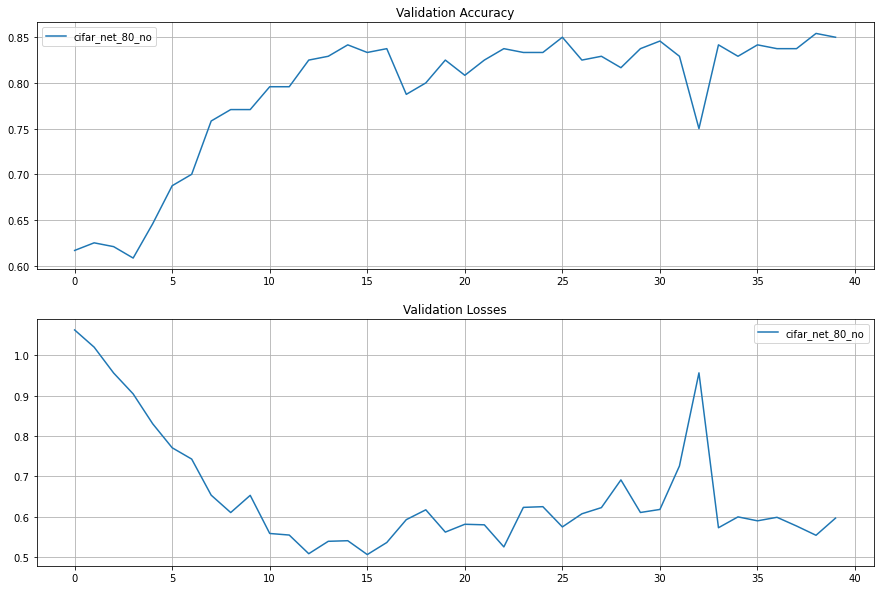

In [49]:
fig,(ax,bx) = plt.subplots(2,figsize=(15,10))
for experiment_id in accuracies.keys():
    ax.plot(accuracies[experiment_id], label=experiment_id)
    ax.legend()
    ax.set_title('Validation Accuracy');
ax.grid()
for experiment_id in accuracies.keys():
    bx.plot(losses[experiment_id], label=experiment_id)
    bx.legend()
    bx.set_title('Validation Losses');
bx.grid()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward>))


In [6]:
def prepare_sequence(seq, to_ix):    
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [65]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, gg = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores, gg

In [67]:
for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        
        # Step 3. Run our forward pass.
        tag_scores, gg = model(sentence_in)
        
        # Step 4. Compute the loss, gradients, and update the parameters by
#          calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        print(gg)
        loss.backward()
        optimizer.step()

(tensor([[[-0.0571,  0.1878, -0.0856,  0.0757,  0.0677,  0.0306]]],
       grad_fn=<StackBackward>), tensor([[[-0.1386,  0.4112, -0.1636,  0.2027,  0.2051,  0.0716]]],
       grad_fn=<StackBackward>))
(tensor([[[ 0.0655,  0.0048, -0.1308,  0.1827,  0.1053, -0.0667]]],
       grad_fn=<StackBackward>), tensor([[[ 0.1254,  0.0141, -0.3582,  0.5021,  0.1867, -0.1121]]],
       grad_fn=<StackBackward>))


In [49]:
training_data

[(['The', 'dog', 'ate', 'the', 'apple'], ['DET', 'NN', 'V', 'DET', 'NN']),
 (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN'])]

In [66]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

(tensor([[-0.9521, -1.2469, -1.1188],
        [-0.9776, -1.2103, -1.1219],
        [-0.9670, -1.1796, -1.1636],
        [-0.9780, -1.1728, -1.1570],
        [-0.9431, -1.2840, -1.0977]]), (tensor([[[-0.0020,  0.0817,  0.0272,  0.1607, -0.1000, -0.0290]]]), tensor([[[-0.0039,  0.1911,  0.1016,  0.2715, -0.2166, -0.1310]]])))
(tensor([[-0.9598, -0.8448, -1.6747],
        [-0.9409, -0.8438, -1.7168],
        [-0.9723, -0.8566, -1.6237],
        [-0.9785, -0.8351, -1.6592],
        [-1.0014, -0.8165, -1.6573]]), (tensor([[[-0.0571,  0.1878, -0.0856,  0.0757,  0.0677,  0.0306]]]), tensor([[[-0.1386,  0.4112, -0.1636,  0.2027,  0.2051,  0.0716]]])))


AttributeError: 'tuple' object has no attribute 'dim'